# Series temporales

- [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Keras LSTM Tutorial](http://adventuresinmachinelearning.com/keras-lstm-tutorial/)
- [Visual Analysis for Recurrent Neural Networks](http://lstm.seas.harvard.edu/client/index.html)
- [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

In [1]:
import pandas, numpy, time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras.backend import clear_session

In [3]:
# convert an array of values into a sliding window dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

def get_predictions(model, scaler, kX, y=None):
    """
    y: not used in prediction, only to get the transformation back
    """
    s_preds = model.predict(kX)
    if scaler is not None:
        s_preds = scaler.inverse_transform(s_preds)
        
    if y is not None:
        s_y     = scaler.inverse_transform(y) if scaler is not None else y
        return s_y[0], s_preds[:,0]
    else:
        return s_preds

def get_RMSE(model, scaler, kX, y):

    sy,spreds = get_predictions(model, scaler, kX, y)
    return np.sqrt(np.mean((sy-spreds)**2))

def plot_predictions(dataset, ktrainX, trainY, ktestX, testY, model, scaler, look_back):
    sy_train, spreds_train = get_predictions(model, scaler, ktrainX, [trainY])
    sy_test,  spreds_test  = get_predictions(model, scaler, ktestX, [testY])
    
    plt.figure(figsize=(20,5))
    plt.plot(range(look_back, look_back+len(spreds_train)), spreds_train,
            label="predictions train", color="blue", lw=2)
    plt.plot(range(look_back, look_back+len(spreds_train)), sy_train,
            label="target train", color="blue", lw=2, alpha=.3)

    plt.plot(range(look_back+len(spreds_train), look_back+len(spreds_train)+len(spreds_test)), 
             spreds_test, label="predictions test", color="red", lw=2)
    plt.plot(range(look_back+len(spreds_train), look_back+len(spreds_train)+len(spreds_test)), 
             sy_test,         
             label="target test", color="red", lw=2, alpha=.3)
    
    plt.plot(scaler.inverse_transform(dataset), color="black", label="data", lw=3, alpha=.2)
    plt.legend(loc=2)
    plt.xlim(0,len(dataset))
    plt.xticks(range(0,len(dataset),2));
    plt.grid()

    
def get_model(lstm_size, input_shape):
    clear_session()
    model = Sequential()
    lstm = LSTM(units=lstm_size, input_shape=input_shape, recurrent_activation="sigmoid")
    dense = Dense(1)
    model.add(lstm)
    model.add(dense)
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
    
def rnn_experiment(dataset, look_back, lstm_size, batch_size, epochs, scaler, pct_train=0.67):

    train_size  = int(len(dataset) * 0.67)
    test_size   = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size-look_back:len(dataset),:]    
    
    trainX, trainY = create_dataset(train, look_back)
    testX, testY   = create_dataset(test, look_back)
    ktrainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1],1))
    ktestX  = numpy.reshape(testX, (testX.shape[0], testX.shape[1],1))

    print "building RNN",
    model = get_model(lstm_size, ktrainX.shape[1:])
    print "fitting RNN"
    mhist = model.fit(ktrainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)

    sy_train, spreds_train = get_predictions(model, scaler, ktrainX, [trainY])
    sy_test,  spreds_test  = get_predictions(model, scaler, ktestX, [testY])
    print "train score: %.2f RMSE"%get_RMSE(model, scaler, ktrainX, [trainY])
    print "test score:  %.2f RMSE"%get_RMSE(model, scaler, ktestX, [testY])
        
    y, preds         = sy_test, spreds_test
    y_delta, p_delta = (y[1:]>y[:-1]), preds[1:]>preds[:-1]
    print "trend prediction accuracy (test)  %.2f"%np.mean(y_delta==p_delta)

    y, preds         = sy_train, spreds_train
    y_delta, p_delta = (y[1:]>y[:-1]), preds[1:]>preds[:-1]
    print "trend prediction accuracy (train) %.2f"%np.mean(y_delta==p_delta)
    
    plot_predictions(dataset, ktrainX, trainY, ktestX, testY, model, scaler, look_back)


## 1. load and preprocess dataset

- example and dataset obtained from [Time series prediction with LSTM Recurrent Neural Networks in Python with Keras](http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

- dataset is scaled to [0,1]

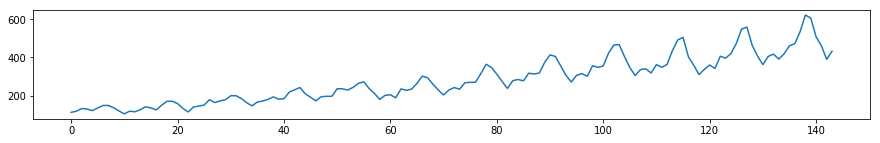

In [12]:
dataset = pd.read_csv('data/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataset.values
dataset = dataset.astype('float32')
plt.figure(figsize=(15,2))
plt.plot(dataset)


In [13]:
np.random.seed()

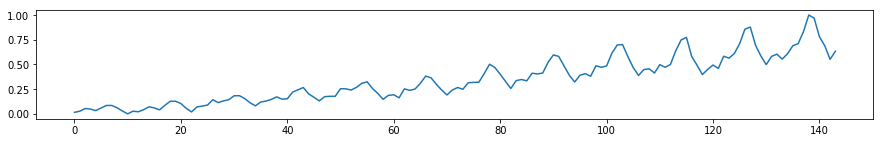

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
plt.figure(figsize=(15,2))
plt.plot(dataset)

### split original signal into train and test

In [15]:
look_back=3

train_size  = int(len(dataset) * 0.67)
test_size   = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size-look_back:len(dataset),:]
print train.shape, test.shape

(96, 1) (51, 1)


### creating time framed dataset

- reshape into $X=[x_{t-n},..., x_{t-1}, x_t]$ and $Y=x_{t+1}$
- reshape for Keras into 3D array (as for multiple signals although in this case we only use one signal)

In [16]:
trainX, trainY = create_dataset(train, look_back)
testX, testY   = create_dataset(test, look_back)
ktrainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1],1))
ktestX  = numpy.reshape(testX, (testX.shape[0], testX.shape[1],1))

In [17]:
print "full original signal     ", dataset.shape
print "original signal     train", train.shape, "test", test.shape
print "time framed signal  train", trainX.shape, "test", testX.shape
print "keras input signal  train", ktrainX.shape, "test", ktestX.shape

full original signal      (144, 1)
original signal     train (96, 1) test (51, 1)
time framed signal  train (93, 3) test (48, 3)
keras input signal  train (93, 3, 1) test (48, 3, 1)


In [18]:
print train[:10,0]
print trainX[:5]
print trainY[:5]

[0.01544401 0.02702703 0.05405405 0.04826255 0.03281853 0.05984557
 0.08494207 0.08494207 0.06177607 0.02895753]
[[0.01544401 0.02702703 0.05405405]
 [0.02702703 0.05405405 0.04826255]
 [0.05405405 0.04826255 0.03281853]
 [0.04826255 0.03281853 0.05984557]
 [0.03281853 0.05984557 0.08494207]]
[0.04826255 0.03281853 0.05984557 0.08494207 0.08494207]


### podríamos usar cual método de ML con este dataset

In [19]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(trainX, trainY)

/opt/miniconda/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

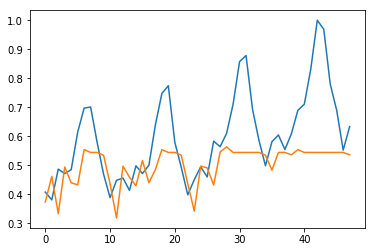

In [20]:
plt.plot(testY)
plt.plot(rf.predict(testX))

## 2. RNN definition and fitting

In [21]:
## build RNN

model = get_model(50, input_shape=[3,1])
clear_session()
model = Sequential()
lstm = LSTM(units=50, input_shape=[3,1], recurrent_activation="sigmoid")
dense = Dense(1)
model.add(lstm)
model.add(dense)
model.compile(loss='mean_squared_error', optimizer='adam')

In [22]:
trainY

array([0.04826255, 0.03281853, 0.05984557, 0.08494207, 0.08494207,
       0.06177607, 0.02895753, 0.        , 0.02702703, 0.02123553,
       0.04247104, 0.07142857, 0.05984557, 0.04054055, 0.08687258,
       0.12741312, 0.12741312, 0.10424709, 0.05598456, 0.01930502,
       0.06949806, 0.07915059, 0.08880308, 0.14285713, 0.11389962,
       0.13127413, 0.14285713, 0.18339768, 0.18339768, 0.15444016,
       0.11196911, 0.08108109, 0.1196911 , 0.12934363, 0.14671814,
       0.17181468, 0.14864865, 0.15250966, 0.22007722, 0.24324325,
       0.26640925, 0.2027027 , 0.16795367, 0.13127413, 0.17374519,
       0.17760617, 0.17760617, 0.25482625, 0.25289574, 0.24131274,
       0.26833975, 0.3088803 , 0.32432434, 0.25675675, 0.20656371,
       0.14671814, 0.18725869, 0.19305018, 0.16216215, 0.25289574,
       0.23745173, 0.25096524, 0.3088803 , 0.38223937, 0.36486486,
       0.2992278 , 0.24131274, 0.1911197 , 0.24131274, 0.26640925,
       0.24903473, 0.31467178, 0.3185328 , 0.32046333, 0.40733

In [23]:
mhist = model.fit(ktrainX, trainY, epochs=100, batch_size=10, verbose=1)

Epoch 1/100
93/93 [==============================] - 1s 15ms/step - loss: 0.0639
Epoch 2/100
93/93 [==============================] - 0s 785us/step - loss: 0.0319
Epoch 3/100
93/93 [==============================] - 0s 807us/step - loss: 0.0159
Epoch 4/100
93/93 [==============================] - 0s 876us/step - loss: 0.0108
Epoch 5/100
93/93 [==============================] - 0s 701us/step - loss: 0.0105
Epoch 6/100
93/93 [==============================] - 0s 653us/step - loss: 0.0094
Epoch 7/100
93/93 [==============================] - 0s 653us/step - loss: 0.0084
Epoch 8/100
93/93 [==============================] - 0s 723us/step - loss: 0.0078
Epoch 9/100
93/93 [==============================] - 0s 835us/step - loss: 0.0070
Epoch 10/100
93/93 [==============================] - 0s 795us/step - loss: 0.0065
Epoch 11/100
93/93 [==============================] - 0s 677us/step - loss: 0.0060
Epoch 12/100
93/93 [==============================] - 0s 840us/step - loss: 0.0055
Epoch 13/100
9

93/93 [==============================] - 0s 666us/step - loss: 0.0033


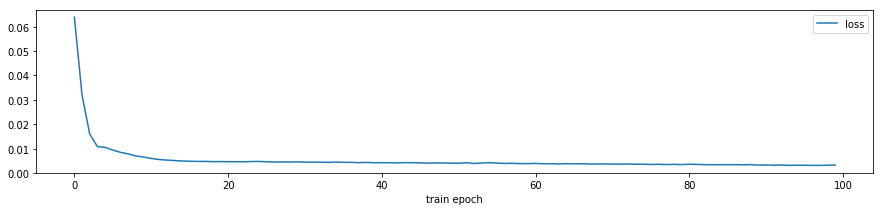

In [24]:
plt.figure(figsize=(15,3))
plt.plot(mhist.history["loss"], label="loss")
plt.xlabel("train epoch")
plt.legend()

### compute and visualize predictions and errors

train score: 29.01 RMSE
test score:  58.22 RMSE
trend prediction accuracy (test)  0.57
trend prediction accuracy (train) 0.54


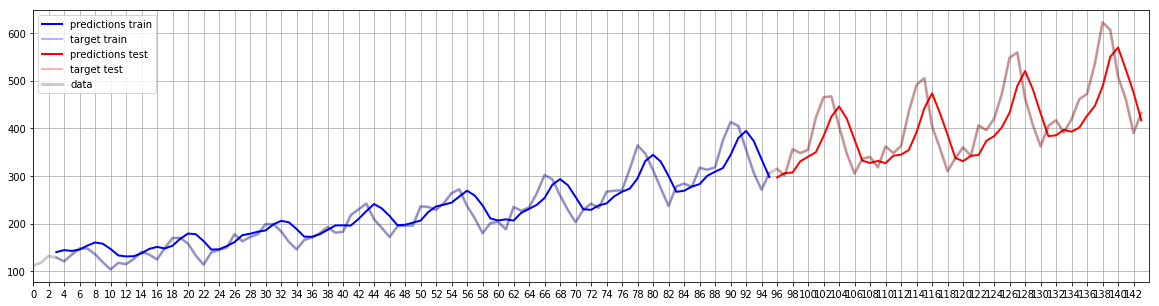

In [25]:
sy_train, spreds_train = get_predictions(model, scaler, ktrainX, [trainY])
sy_test,  spreds_test  = get_predictions(model, scaler, ktestX, [testY])
print "train score: %.2f RMSE"%get_RMSE(model, scaler, ktrainX, [trainY])
print "test score:  %.2f RMSE"%get_RMSE(model, scaler, ktestX, [testY])

y, preds         = sy_test, spreds_test
y_delta, p_delta = (y[1:]>y[:-1]), preds[1:]>preds[:-1]
print "trend prediction accuracy (test)  %.2f"%np.mean(y_delta==p_delta)

y, preds         = sy_train, spreds_train
y_delta, p_delta = (y[1:]>y[:-1]), preds[1:]>preds[:-1]
print "trend prediction accuracy (train) %.2f"%np.mean(y_delta==p_delta)

plot_predictions(dataset, ktrainX, trainY, ktestX, testY, model, scaler, look_back)


### compute trend prediction error (up or down) 

In [26]:
y = sy_test
preds = spreds_test
print "RMSE (check) %.2f"%np.sqrt(np.mean((y-preds)**2))

y_delta = (y[1:]>y[:-1])
p_delta = preds[1:]>preds[:-1]
print "trend prediction accuracy %.2f"%np.mean(y_delta==p_delta)

RMSE (check) 58.22
trend prediction accuracy 0.57


## 4. Fine tune RNN

observe with the network such as above, predictions can be seen as the input delayed ... so it is not really learning much

building RNN fitting RNN
train score: 23.01 RMSE
test score:  59.40 RMSE
trend prediction accuracy (test)  0.55
trend prediction accuracy (train) 0.51


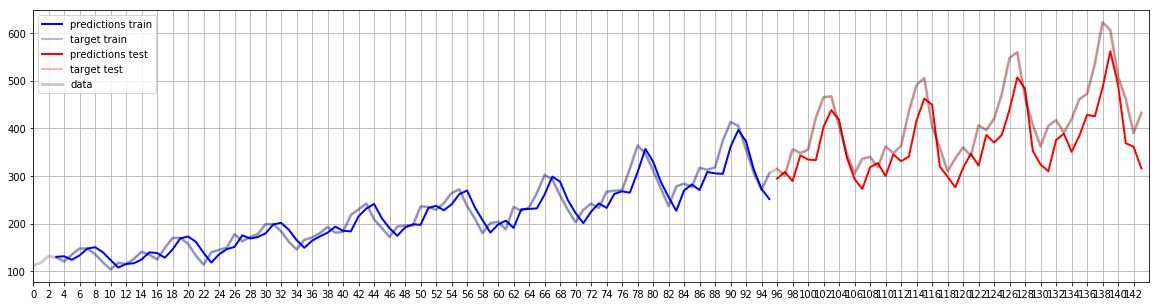

In [27]:
rnn_experiment(dataset, look_back=3, lstm_size=50, batch_size=10, epochs=200, scaler=scaler)

try out with different parameters

building RNN fitting RNN
train score: 25.00 RMSE
test score:  78.11 RMSE
trend prediction accuracy (test)  0.57
trend prediction accuracy (train) 0.59


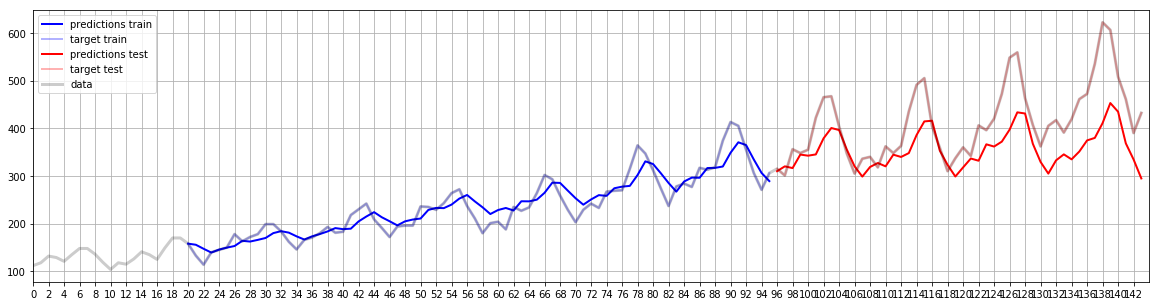

In [28]:
rnn_experiment(dataset, look_back=20, lstm_size=5, batch_size=10, epochs=200, scaler=scaler)

building RNN fitting RNN
train score: 32.17 RMSE
test score:  70.73 RMSE
trend prediction accuracy (test)  0.53
trend prediction accuracy (train) 0.55


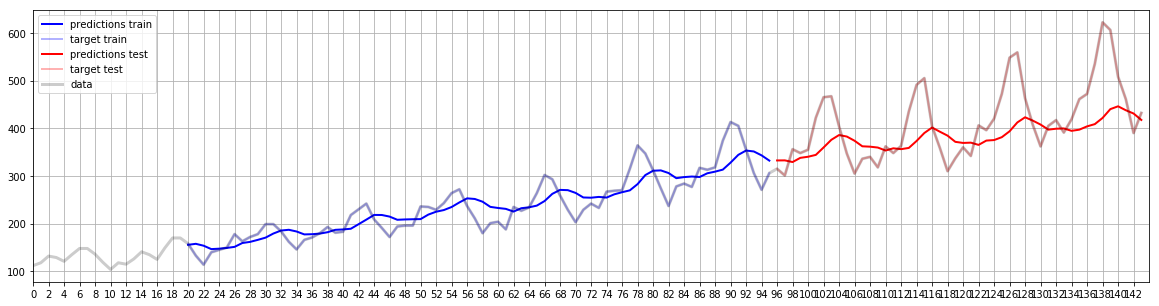

In [29]:
rnn_experiment(dataset, look_back=20, lstm_size=5, batch_size=10, epochs=150, scaler=scaler)

building RNN fitting RNN
train score: 20.63 RMSE
test score:  45.05 RMSE
trend prediction accuracy (test)  0.66
trend prediction accuracy (train) 0.72


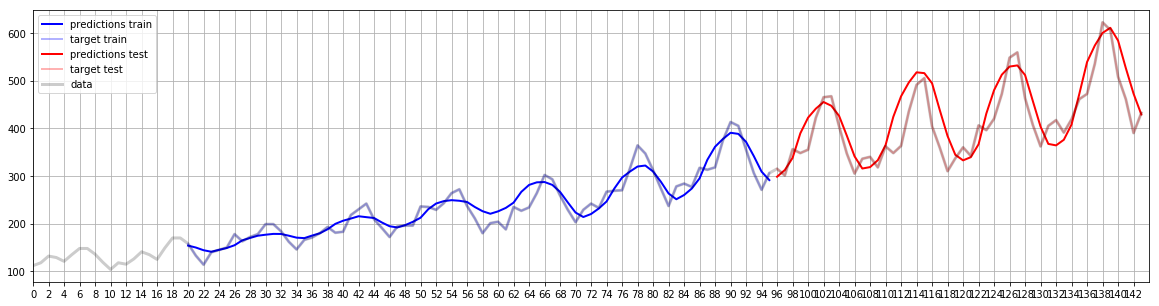

In [32]:
rnn_experiment(dataset, look_back=20, lstm_size=30, batch_size=10, epochs=150, scaler=scaler)